# Filter pixel classifications results by segments

To Do:
- multiband inputs to rsgislib.shpeherdseg ?
- custom statistics to zonal stats? https://pythonhosted.org/rasterstats/manual.html#user-defined-statistics


        def mymean(x):
           return np.ma.mean(x)

        zonal_stats("tests/data/polygons.shp",
                    "tests/data/slope.tif",
                    stats="count",
                     add_stats={'mymean':mymean})

- instead of zonal_stats_parallel use RSGISLIB's raster-attribute-tables to assign pixel values to clumps?

In [9]:
import os
import sys
import gdal
import shutil
import xarray as xr
import geopandas as gpd
import subprocess as sp
from datacube.utils.cog import write_cog
from rsgislib.segmentation import segutils

sys.path.append('../../Scripts')
from deafrica_classificationtools import HiddenPrints
from deafrica_spatialtools import xr_rasterize, xr_vectorize, zonal_stats_parallel

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis Parameters

In [2]:
test_shapefile = 'data/eastern_testing_sites.geojson'

results = 'results/classifications/'

model_type='gm_mads_two_seasons'

min_seg_size=200 #in number of pixels

### Open testing tile shapefile

In [3]:
gdf = gpd.read_file(test_shapefile)

## Image segmentation

1. Generate image segments
2. Vectorize segments
3. Calculate zonal 'majority' statistic over vectorized segments
4. Rasterize segments using 'majority' as pixel values.
5. Write object-based classification to disk

### Automatically find the number of cpus

In [4]:
try:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-4:]))
except:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-3:]))

print('ncpus = '+str(ncpus))

ncpus = 31


In [16]:
%%time
for g_id in gdf['GRID_ID'][2:].values:
    print('working on grid: ' + g_id)
    
    #store temp files somewhere
    directory=results+'tmp_'+g_id
    if not os.path.exists(directory):
        os.mkdir(directory)
    
    tmp='tmp_'+g_id+'/'
    
    #inputs to image seg
    tiff_to_segment = results+'Eastern_tile_'+g_id+'_NDVI_S1.tif'
    kea_file = results+'Eastern_tile_'+g_id+'_NDVI_S1.kea'
    segmented_kea_file = results+'Eastern_tile_'+g_id+'_segmented.kea'

    #convert tiff to kea
    gdal.Translate(destName=kea_file,
                   srcDS=tiff_to_segment,
                   format='KEA',
                   outputSRS='EPSG:6933')
    
    #run image seg
    print('   image segmentation...')
    with HiddenPrints():
        segutils.runShepherdSegmentation(inputImg=kea_file,
                                         outputClumps=segmented_kea_file,
                                         tmpath=results+tmp,
                                         numClusters=60,
                                         minPxls=min_seg_size)
    
    #open segments
    da=xr.open_rasterio(segmented_kea_file).squeeze()

    #convert to polygons and export to disk
    print('   writing segments to shapefile...')
    with HiddenPrints():
        gdf_seg = xr_vectorize(da, attribute_col='attribute')
    print("   Number of segments: "+str(len(gdf_seg)))
    gdf_seg.to_file(results+tmp+'Eastern_tile_'+g_id+'_segments.shp')
    
    #calculate zonal-stats
    print('   zonal statistics...')
    zonal_stats_parallel(shp=results+tmp+'Eastern_tile_'+g_id+'_segments.shp',
           raster=results+ 'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'.tif',
           statistics=['majority'],
           out_shp=results+tmp+'Eastern_tile_'+g_id+"_zonal_stats.shp",
           ncpus=ncpus if ncpus<25 else 25, #otherwise too much mem consumption
           nodata=-1
               )
    
    #rasterize the zonal-stats
    with HiddenPrints():
        gdf_zs=gpd.read_file(results+tmp+'Eastern_tile_'+g_id+"_zonal_stats.shp")
        predict_zs = xr_rasterize(gdf_zs, da, attribute_col='majority')
    
    #write to disk
    write_cog(predict_zs, results+ 'Eastern_tile_'+g_id+'_prediction_object_'+model_type+'.tif', overwrite=True)
    
    #remove the tmp folder
    shutil.rmtree(results+tmp)
    os.remove(kea_file)
    os.remove(segmented_kea_file)

working on grid: B-19
   image segmentation...
   writing segments to shapefile...
   Number of segments: 188529
   zonal statistics...
working on grid: D-17
   image segmentation...


KeyboardInterrupt: 

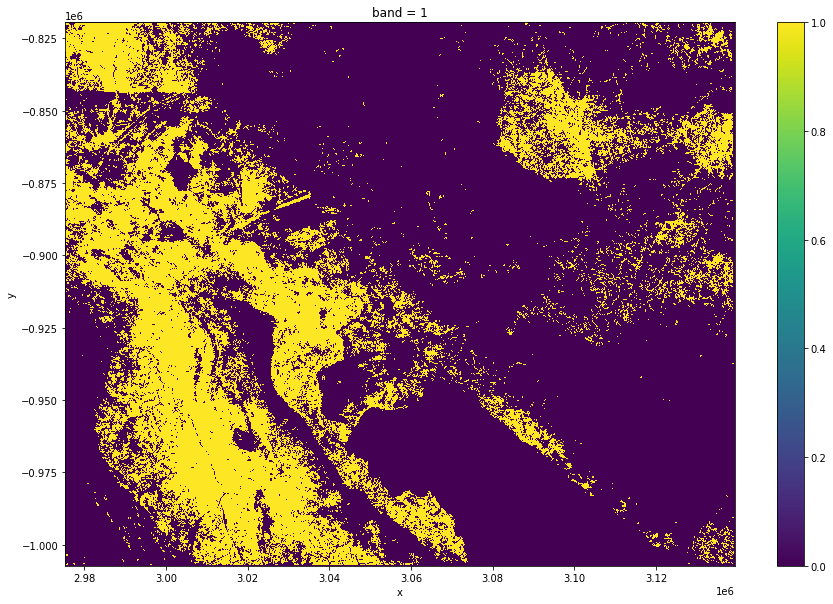

In [19]:
xr.open_rasterio(results+ 'Eastern_tile_'+'B-19'+'_prediction_object_'+model_type+'.tif').squeeze().plot(size=10)

***
## RSGISlib Shepherd Seg tiled examples

### single cpu, tiled

In [ ]:
%time
# #run the segmentation
with HiddenPrints():
    tiledsegsingle.performTiledSegmentation(kea_file,
                                    segmented_kea_file,
                                    tmpDIR=temp,
                                    numClusters=60,
                                    validDataThreshold=validDataTileFraction, 
                                    tileWidth=width,
                                    tileHeight=height,
                                    minPxls=9)

In [ ]:
# Attribute segments with zonal mean of input image and output as geotiff
meanImage(tiff_to_segment, segmented_kea_file, segments_zonal_mean, "GTIFF",rsgislib.TYPE_32FLOAT)

### n cpus, tiled

In [ ]:
# %time
#run the segmentation
with HiddenPrints():
    tiledSegParallel.performTiledSegmentation(kea_file,
                                segmented_kea_file,
                                tmpDIR=temp,
                                numClusters=60,
                                validDataThreshold=validDataTileFraction, 
                                tileWidth=width,
                                tileHeight=height,
                                minPxls=9,
                                ncpus=ncpus)

# Attribute segments with zonal mean of input image and output as geotiff
meanImage(tiff_to_segment, segmented_kea_file, segments_zonal_mean, "GTIFF",rsgislib.TYPE_32FLOAT)

Dask parallel zonal stats (seems really slow)

In [ ]:
# %%time
# pred = xr.open_rasterio(results+ 'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'.tif').squeeze()
# arr = pred.values
# affine = pred.geobox.affine

# #gdf_segrt geopandas dataframe to dask dataframe
# data_dd = dd.from_pandas(z, npartitions=15)

# #fin majority of pixel
# res = data_dd.map_partitions(lambda df: df.assign(majority=pd.DataFrame(zonal_stats(vectors=z['geometry'],
#                                            affine=affine,
#                                            raster=arr,
#                                            stats='majority'))['majority']),
#                                             meta=data_dd).compute()
# print(res)